# Set-up

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

from pathlib import Path
from tqdm import tqdm
import gc

import os
import pandas as  pd
import numpy as np
from math import floor
from scipy.linalg import sqrtm
!pip3 install pickle5
import pickle5
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape, Activation, Embedding, Input
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, RepeatVector, concatenate
from tensorflow.keras.layers import LSTM, Lambda, Concatenate
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from keras.regularizers import l2
#from keras.preprocessing.text import one_hot
import random
random.seed(2345)

     |████████████████████████████████| 132 kB 14.3 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219328 sha256=b30ab898c0c5caec78444098ab162fac639036a06c56aad322dc075b78f965a2
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [ ]:
os.getcwd()
os.chdir('.\\Data')
os.getcwd()

In [ ]:
results_path = Path('./model/Gan1')
log_dir = results_path
# Set up logger
writer = tf.summary.create_file_writer(log_dir.as_posix())

# Load Data

In [ ]:
def extract_data(df_name='dataf_interp2', DV='lCloseAvg', drop=['name','Office']):
    # Load data
    data = []
    with open('./'+df_name+'.pkl','rb') as file:
        data = pickle5.load(file)
    data = pd.DataFrame(data)
    data = data.reset_index(drop=True)
    
    global dv
    dv = [DV]
    
    # Plot DV
    plt.scatter(data.loc[:,"date"],data.loc[:,dv])
    plt.xlabel("Date")
    plt.ylabel("DV")
    plt.show()

    names = data[["cik","name"]].drop_duplicates(ignore_index=True)
    names = names.set_index(['cik'])
    
    # Drop columns
    if len(drop)>0:
        data = data.drop(drop,1)

    # Conver categorical variables
    
    # Sectors
    sectors = data['sic'].unique()
    one_hot = pd.get_dummies(data['sic'])
    sic = one_hot.columns.values # create helper array
    data = data.drop('sic',axis = 1) # drop categorical column
    data = data.join(one_hot) # join the encoder
    
    # Countries - keep only most frequent segments and group together the rest
    # "US", "CA", "CN"
    countries_keep = ["US", "CA", "CN"]
    for i in range(len(data)):
        if data.loc[i,'countryba'] not in countries_keep:
            data.loc[i,['countryba']] = 'OT'
    one_hot = pd.get_dummies(data['countryba'])
    country = one_hot.columns.values # create helper array
    data = data.drop('countryba',axis = 1) # drop categorical column
    data = data.join(one_hot) # join the encoder
       
    # Create helper arrays
    id = ['cik', 'date']
    companies = data['cik'].unique()
    character = list(sic) + list(country)
    macroec = ['gdp','cpi','eir','unemployment','disp_inc','oil','ici']
    ratios = ['CurrentRatio', 'CashRatio', 'DebtRatio', 'DebtToEquity',
              'ReturnOnAssets', 'ReturnOnEquity']
    ind_vals = ['INTERESTPAID','PROCEEDSFROMISSUANCEOFCOMMONSTOCK',
                 'SHAREBASEDCOMPENSATION',
                 'STOCKISSUEDDURINGPERIODVALUENEWISSUES']
    all_var = [var for var in data.columns if var not in id+dv]
    all_var1 = [var for var in data.columns if var not in id+dv+macroec]
    numeric1 = [var for var in data.columns if var not in id+dv+character+macroec+ind_vals] # variables to normalize
    numeric2 = [var for var in data.columns if var not in id+dv+character+macroec+ind_vals+ratios] # variables to use in PCA (since ratios were derived from other variables they can be excluded)
    fin_var = [var for var in data.columns if var not in id+dv+ratios+macroec+character]
   
    helper = {'id': id, 'companies': companies, 'sectors': sectors, 'character': character,
              'macroec': macroec, 'ratios': ratios, 'ind_vals': ind_vals,
              'all_var': all_var, 'all_var1': all_var1, 'numeric1': numeric1,
              'numeric2': numeric2, 'fin_var': fin_var, 'names': names}
    # Convert all to float64
    for var in numeric1:
        data[var] = data[var].astype('float64')
    
    return data, helper


# Prepare Data for Training

In [ ]:
def convert_timeseries(data, n_in=1, ts_out=1, dropnan=True):
    appended_data = []
#    n_vars = 1 if type(data) is list else data.shape[1]
    for co in companies:
        #covert timeseries data to t-n to t-1 form
        #n defines how many previous value should be taken into consideration
        df = data.loc[[co]]
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [j + '(t-%d)' %(i) for j in data.columns]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, ts_out):
            cols.append(df[dv].shift(-i))
            if i == 0:
                names += [('dv')]
            else:
                names += [('dv%d' % (i))]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        appended_data.append(agg)
    appended_data = pd.concat(appended_data)
    return appended_data

In [ ]:
# Transform data into 3D format with timesteps, scale
# Split on train/valid/test with retained order of observations
###############################################
def prepare_data_order(data, vars, val_mths=4, ts=1, dv_lag=1):
    # Reset index to include Company&Date
    data2 = data[id+vars].copy()
    data2 = data2.sort_values(['cik','date']).reset_index(drop=True)
    data2.index = pd.MultiIndex.from_arrays(data[id].values.T, names=['cik', 'date'])
    data2.drop(id,axis=1,inplace=True)
    
    # Train/Test split
    train_ind = []
    valid_ind = []
    test_ind = []
    companies = data2.reset_index().cik.unique()
    for co in companies:
        df = data2.loc[[co]]
        train_ind.append(df.index.tolist()[:df.shape[0]-2*val_mths])
        valid_ind.append(df.index.tolist()[df.shape[0]-2*val_mths-ts:df.shape[0]-val_mths])
        test_ind.append(df.index.tolist()[df.shape[0]-val_mths-ts:])
    train = [item for sublist in train_ind for item in sublist]
    valid = [item for sublist in valid_ind for item in sublist]
    test = [item for sublist in test_ind for item in sublist]
    
    data_train1 = data2.loc[train,:]
    data_valid1 = data2.loc[valid,:]
    data_test1 = data2.loc[test,:]
    
     # Scale the data
    scaler = MinMaxScaler()
    scaler_dv = MinMaxScaler()
    data_train2 = pd.DataFrame(scaler.fit_transform(data_train1),columns=data_train1.columns, index=data_train1.index)
    scaler_dv.fit_transform(data_train1[dv])
    data_valid2 = pd.DataFrame(scaler.transform(data_valid1),columns=data_valid1.columns, index=data_valid1.index)
    data_test2 = pd.DataFrame(scaler.transform(data_test1),columns=data_test1.columns, index=data_test1.index)
    scalers = [scaler,scaler_dv]
    
    # Add lags/timesteps
    train_lag = convert_timeseries(data_train2, n_in=ts, ts_out=ts_out) 
    x_train = train_lag.values[:,:-ts_out]
    y_train = train_lag.values[:,-ts_out:]

    valid_lag = convert_timeseries(data_valid2, n_in=ts, ts_out=ts_out) 
    x_valid = valid_lag.values[:,:-ts_out]
    y_valid = valid_lag.values[:,-ts_out:]
    
    test_lag = convert_timeseries(data_test2, n_in=ts, ts_out=ts_out) 
    x_test = test_lag.values[:,:-ts_out]
    y_test = test_lag.values[:,-ts_out:]
    
    x_train = x_train.reshape((x_train.shape[0], ts, len(vars)))
    x_valid = x_valid.reshape((x_valid.shape[0], ts, len(vars)))
    x_test = x_test.reshape((x_test.shape[0], ts, len(vars)))

    train_batch = train_lag.reset_index().groupby('cik')['date'].count()
    valid_batch = valid_lag.reset_index().groupby('cik')['date'].count()
    test_batch = test_lag.reset_index().groupby('cik')['date'].count()
    batch_arrays = [train_batch, valid_batch, test_batch]
    
    print("Train: ", x_train.shape, len(y_train))
    print("Valid: ", x_valid.shape, len(y_valid))
    print("Test: ", x_test.shape, len(y_test))
    
    return data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays


In [ ]:
# Transform data into 3D format with timesteps, scale
# Split on train/valid/test with shuffled observations
###############################################
def prepare_data_shuffle(data, vars, val_mths=4, ts=1, n_lag=1, dv_lag=1):
    # Reset index to include Company&Date
    data2 = data[id+vars].copy()
    data2 = data2.sort_values(['cik','date']).reset_index(drop=True)
    data2.index = pd.MultiIndex.from_arrays(data[id].values.T, names=['cik', 'date'])
    data2.drop(id,axis=1,inplace=True)
    
    # Add lags/timesteps
    data_ts = convert_timeseries(data2, n_in=max(ts,n_lag), ts_out=ts_out) 

    # Train/validate/test split
    train = valid = test = []
    train_ds = valid_ds = test_ds = pd.DataFrame()
    for co in companies:
        df = data_ts.loc[[co]]
        #df = df.sample(frac = 1)
        train, valid, test = np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])
        train_ds = train_ds.append(train)
        valid_ds = valid_ds.append(valid)
        test_ds = test_ds.append(test)
        
    # Scale data
    scaler = MinMaxScaler()
    scaler_dv = MinMaxScaler()
    train_ds2 = pd.DataFrame(scaler.fit_transform(train_ds),columns=train_ds.columns, index=train_ds.index)
    scaler_dv.fit_transform(train_ds.iloc[:,-ts_out:])
    valid_ds2 = pd.DataFrame(scaler.transform(valid_ds),columns=valid_ds.columns, index=valid_ds.index)
    test_ds2 = pd.DataFrame(scaler.transform(test_ds),columns=test_ds.columns, index=test_ds.index)
    scalers = [scaler,scaler_dv]
    
    # X/Y split
    x_train = train_ds2.values[:,:-ts_out]
    y_train = train_ds2.values[:,-ts_out:]
    x_valid = valid_ds2.values[:,:-ts_out]
    y_valid = valid_ds2.values[:,-ts_out:]
    x_test = test_ds2.values[:,:-ts_out]
    y_test = test_ds2.values[:,-ts_out:]
    
    x_train = x_train.reshape((x_train.shape[0], ts, n_lag*len(vars)))
    x_valid = x_valid.reshape((x_valid.shape[0], ts, n_lag*len(vars)))   
    x_test = x_test.reshape((x_test.shape[0], ts, n_lag*len(vars)))   

    print("Train: ", x_train.shape, len(y_train))
    print("Valid: ", x_valid.shape, len(y_valid))
    print("Test: ", x_test.shape, len(y_test))
    
    return data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, []

# Define model functions

In [ ]:
# Set up random series generator
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(ts_out, n_seq_in))

# TimeGAN Set up
##############################
def generic_layers(n_layers, hidden_units, output_units, name, activ):
    return Sequential([LSTM(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation=activ,
                             name='OUT')], name=name)

def model0(input1, input2, activ='linear', name='Supervisor', output_units=4, lstm_units=128, kr=0):
    time_series_input1 = Input(shape=(input1.shape[1], input1.shape[2],), name='time_series1')
    time_series_input2 = Input(shape=(input2.shape[1], input2.shape[2],), name='time_series2')
    # Encoder
    lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(kr), activity_regularizer=l2(kr), recurrent_regularizer=l2(kr), name='LSTMe1')(time_series_input1)
    # Decoder
    shrink = Lambda(lambda x: x[:, -output_units:, :])(lstm)
    concat = Concatenate(name='concat')([time_series_input2,shrink])
    lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(kr), activity_regularizer=l2(kr), recurrent_regularizer=l2(kr), name='LSTMd1')(concat)
    lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(kr), activity_regularizer=l2(kr), recurrent_regularizer=l2(kr), name='LSTMd2')(concat)
    lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(kr), activity_regularizer=l2(kr), recurrent_regularizer=l2(kr), name='LSTMd3')(concat)
    lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(kr), activity_regularizer=l2(kr), recurrent_regularizer=l2(kr), name='LSTMd4')(concat)

    output = Dense(units=output_units,activation=activ, name='Dense')(lstm)
    model = Model(inputs=[time_series_input1,time_series_input2], outputs=output)
    return model

def model1(input1, input2, activ='linear', name='Supervisor', output_units=4, lstm_units=128, kr=0):
    time_series_input1 = Input(shape=(input1.shape[1], input1.shape[2],), name='time_series1')
    time_series_input2 = Input(shape=(input2.shape[1], input2.shape[2],), name='time_series2')
    # Encoder
    lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(kr), activity_regularizer=l2(kr), recurrent_regularizer=l2(kr), name='LSTMe1')(time_series_input1)
    # Decoder
    shrink = Lambda(lambda x: x[:, -output_units:, :])(lstm)
    concat = Concatenate(name='concat')([time_series_input2,shrink])
    lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(kr), activity_regularizer=l2(kr), recurrent_regularizer=l2(kr), name='LSTMd1')(concat)

    output = TimeDistributed(Dense(units=1,activation=activ, name='Dense'))(lstm)
    model = Model(inputs=[time_series_input1,time_series_input2], outputs=output)
    return model

# Define optimizer and loss functions
error = MeanSquaredError()
#error = MeanAbsoluteError()
bce = BinaryCrossentropy()
autoencoder_optimizer = Adam()
supervisor_optimizer = Adam()
generator_optimizer = Adam()
embedding_optimizer = Adam()
discriminator_optimizer = Adam()

@tf.function
def train_autoencoder_init(x1, x2):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x2)
        embedding_loss_t0 = error(x1, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

# Supervisor Training
##############################
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        if len(h_hat_supervised.shape)<len(h.shape):
            h_hat_supervised = tf.reshape(h_hat_supervised, h.shape)
        g_loss_s = error(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

# Losses
##############################
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

### Generator Traiin Step
###########################
@tf.function
def train_generator(x1, x2, z):
    with tf.GradientTape() as tape:
        x1 = tf.cast(x1,tf.float32)
        #x2 = tf.cast(x2,tf.float32)
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x2)
        h_hat_supervised = supervisor(h)
        if len(h_hat_supervised.shape)<len(h.shape):
            h_hat_supervised = tf.reshape(h_hat_supervised, h.shape)
        generator_loss_supervised = error(h[:, 1:, :], h_hat_supervised[:, :-1, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x1, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    #return np.array(generator_loss_unsupervised), np.array(generator_loss_supervised), np.array(generator_moment_loss)
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

### Embedding Train Step
##############################
@tf.function
def train_embedder(x1, x2):
    with tf.GradientTape() as tape:
        h = embedder(x2)
        h_hat_supervised = supervisor(h)
        if len(h_hat_supervised.shape)<len(h.shape):
            h_hat_supervised = tf.reshape(h_hat_supervised, h.shape)
        generator_loss_supervised = error(h[:, 1:, :], h_hat_supervised[:, :-1, :])

        x_tilde = autoencoder(x2)
        embedding_loss_t0 = error(x1, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

### Discriminator Train Step
##############################
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e), discriminator_loss_real, discriminator_loss_fake, discriminator_loss_fake_e

@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss, discriminator_loss_real, discriminator_loss_fake, discriminator_loss_fake_e = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss, discriminator_loss_real, discriminator_loss_fake, discriminator_loss_fake_e

# Predictions

In [ ]:
# calculate frechet inception distance
# Source: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
def prediction(scalers, importance=0, autoenc=0):
    # Calculate MSE on train data
    zt_data = []
    for i in range(int(len(x_train)/batch_size)+1):
        Z_ = next(random_series)
        zt_data.append(Z_.numpy())
    Z = np.concatenate([df for df in zt_data])[:len(x_train),:,:1]
    # Calculate predicted values
    generated_datatt = synthetic_data([x_train,Z])[:,:,0]
    yhattt = (scalers[1].inverse_transform(generated_datatt)
                   .reshape(-1, ts_out, n_seq_out))[:,:,0]

    y_acttt = scalers[1].inverse_transform(y_train) # unnormalize
    
    # Calculate RMSE
    print("Performance on Train data:")
    mset = mean_squared_error(y_acttt, yhattt)
    print('Train MSE: %.3f' % mset)
    fid = calculate_fid(y_acttt, yhattt)
    print('Train FID: %.3f' % fid)

    # Calculate MSE on validation data
    zt_data = []
    for i in range(int(len(x_valid)/batch_size)+1):
        Z_ = next(random_series)
        zt_data.append(Z_.numpy())
    Z = np.concatenate([df for df in zt_data])[:len(x_valid),:,:1]
    # Calculate predicted values
    generated_datav = synthetic_data([x_valid,Z])[:,:,0]
    yhatv = (scalers[1].inverse_transform(generated_datav)
                   .reshape(-1, ts_out, n_seq_out))[:,:,0]

    y_actv = scalers[1].inverse_transform(y_valid) # unnormalize
    
    # Calculate RMSE
    print("Performance on Validation data:")
    msev = mean_squared_error(y_actv, yhatv)
    print('Validation MSE: %.3f' % msev)
    fid = calculate_fid(y_actv, yhatv)
    print('Validation FID: %.3f' % fid)

    ### Prediction on Test data
    # Generate Synthetic Data
    zt_data = []
    for i in range(int(len(x_test)/batch_size)+1):
        Z_ = next(random_series)
        zt_data.append(Z_.numpy())
    Z = np.concatenate([df for df in zt_data])[:len(x_test),:,:1]
    # Calculate predicted values
    generated_datat = synthetic_data([x_test,Z])[:,:,0]
    yhatt = (scalers[1].inverse_transform(generated_datat)
                   .reshape(-1, ts_out, n_seq_out))[:,:,0]

    y_actt = scalers[1].inverse_transform(y_test) # unnormalize
    
    # Calculate RMSE
    print("Performance on Test data:")
    rmse = np.sqrt(mean_squared_error(y_actt, yhatt))
    mae = np.sum(abs(y_actt - yhatt))/(yhatt.shape[0]*yhatt.shape[1])
    print('Test RMSE: %.3f' % rmse) 
    print('Test MAE: %.3f' % mae)
    rmse_period = np.sqrt(((y_actt-yhatt)**2).mean(axis=0))
    mae_period = abs(y_actt-yhatt).mean(axis=0)
    for i in range(len(rmse_period)):
        print('Test RMSE period %d: %.3f' %(i,rmse_period[i]))
    for i in range(len(mae_period)):
        print('Test MAE period %d: %.3f' %(i,mae_period[i]))
    fid = calculate_fid(y_actt, yhatt)
    print('Test FID: %.3f' % fid)

    #### Prediction on full dataset
    gc.collect(generation=2)
    # Scale the data
    data_s = pd.DataFrame(scalers[0].transform(data2),columns=data2.columns, index=data2.index)
    # Ad timesteps
    data_all = convert_timeseries(data_s, n_in=ts, ts_out=ts_out)

    label_encoder = LabelEncoder()
    companies_df_all = pd.DataFrame(label_encoder.fit_transform(data_all.reset_index().cik), index=data_all.index)
    
    x_act = data_all.values[:,:-ts_out]
    x_act = x_act.reshape((x_act.shape[0], ts, len(vars)))
    y_act = data_all.values[:,-ts_out:]

    # Generate Synthetic Data
    z_data = []
    for i in range(int(len(x_act)/batch_size)+1):
        Z_ = next(random_series)
        z_data.append(Z_.numpy())
    Z = np.concatenate([df for df in z_data])[:len(x_act),:,:1]
    # Calculate predicted values
    generated_data = synthetic_data([x_act,Z])[:,:,0]
    yhat = (scalers[1].inverse_transform(generated_data)
                   .reshape(-1, ts_out, n_seq_out))[:,:,0]

    y_act = scalers[1].inverse_transform(y_act) # unnormalize
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_act, yhat))
    print('Full RMSE: %.3f' % rmse) 
    rmse_period = np.sqrt(((y_act-yhat)**2).mean(axis=0))
    for i in range(len(rmse_period)):
        print('Full RMSE period %d: %.3f' %(i,rmse_period[i]))
    # Calculate FID
    fid = calculate_fid(y_act, yhat)
    print('Full FID: %.3f' % fid)
    
    # Plot Act vs Exp scatterplot
    for i in range(yhat.shape[1]):
        ys = pd.DataFrame()
        ys['act'] = y_act[:,i]
        ys['exp'] = yhat[:,i]
        ys.index = pd.MultiIndex.from_arrays(data_all.reset_index()[id].values.T, names=['cik', 'date'])
    
        plt.scatter(ys.loc[:,"act"],ys.loc[:,"exp"])
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title('Period %d' % i)
        plt.xlim([ys.act.min(), ys.act.max()]) 
        plt.ylim([ys.act.min(), ys.act.max()])
        plt.show()

    # Find impact of each var on RMSE
    impt_var = pd.DataFrame(columns=['Var', 'RMSE'])
    if importance==1:
        j=0
        for i in range(x_act.shape[2]):
            test_Xt = x_act.copy()
            test_Xt[:,:,i] = 0
            Zallt = np.concatenate([Z,test_Xt],axis=2)
            # Calculate predicted values
            generated_datat = synthetic_data(Zallt)[:,:,0]
            yhatt = (scalers[1].inverse_transform(generated_datat)
                   .reshape(-1, ts, n_seq_out))[:,:,0]
            
            rmset = np.sqrt(mean_squared_error(y_act, yhatt))
            drmse = rmset - rmse
            impt_var.loc[j,'var'] = all_lag.columns[j]
            impt_var.loc[j,'RMSE'] = drmse
            gc.collect(generation=2)
            j+=1
        plt.show()

    return data_all, y_act, yhat, y_actt, yhatt, impt_var, mset, msev

def sample_plot(co=13, f_yr=4, step=1):
    forecast = pd.DataFrame(yhat)
    forecast.index = pd.MultiIndex.from_arrays(all_lag.reset_index()[id].values.T, names=['cik', 'date'])
    forecast_co = forecast.loc[co,:]
    series = pd.DataFrame(y_act)
    series.index = pd.MultiIndex.from_arrays(all_lag.reset_index()[id].values.T, names=['cik', 'date'])
    series_co = series.loc[co,[0]]
    # add last quarters to actual data
    for i in range(series.shape[1]-1):
        add_month = pd.DataFrame(series.loc[co,i+1][-1:])
        add_month.index=add_month.reset_index().date+ pd.DateOffset(months=3*(i+1))
        add_month.columns=series_co.columns
        series_co = series_co.append(add_month)
    # Plot actual and forecast 
    dates = series_co.reset_index().date
    n_test = min(f_yr*4,floor(len(series_co)/step)*4)
    plt.plot(series_co, label="Actual")
    for i in range(0,n_test,step):
        off_s = max(0,len(series_co) - n_test + i - 1)
        off_e = min(len(series_co),off_s + len(forecast_co.values[i]) + 1)
        xaxis = [dates[x] for x in range(off_s, off_e)]
        yaxis = [series_co.values[off_s]]
        yaxis.extend(forecast_co.values[off_s+1])
        if i==0:
          plt.plot(xaxis, yaxis,'-',color='red', label="Predicted")
        else:
          plt.plot(xaxis, yaxis,'-',color='red')
    name = names.loc[co,'name'] if len(names.loc[co,])==1 else names.loc[co,'name'][0]
    plt.xlabel("Time")
    plt.ylabel("Ln(price)")
    plt.legend()
    plt.title(name)
    plt.show()        

In [ ]:
from sklearn.decomposition import PCA
def PCA_Analysis (dataX, dataX_hat):
  
    # Analysis Data Size
    Sample_No = min(len(dataX)-100, len(dataX_hat)-100)
    
    # Data Preprocessing
    for i in range(Sample_No):
        if (i == 0):
            arrayX = np.reshape(np.asarray(dataX[0]), [1,len(dataX[0])])
            arrayX_hat = np.reshape(np.asarray(dataX_hat[0]), [1,len(dataX[0])])
        else:
            arrayX = np.concatenate((arrayX, np.reshape(np.asarray(dataX[i]), [1,len(dataX[0])])))
            arrayX_hat = np.concatenate((arrayX_hat, np.reshape(np.asarray(dataX_hat[i]), [1,len(dataX[0])])))
    
    # Parameters        
    No = len(arrayX[:,0])
    colors = ["red" for i in range(No)] +  ["blue" for i in range(No)]    
    
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(arrayX)
    pca_results = pca.transform(arrayX)
    pca_hat_results = pca.transform(arrayX_hat)
        
    # Plotting
    f, ax = plt.subplots(1)
    
    plt.scatter(pca_results[:,0], pca_results[:,1], c = colors[:No], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], c = colors[No:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()    

In [ ]:
def tSNE_Analysis (dataX, dataX_hat):
  
    # Analysis Data Size
    Sample_No = min(len(dataX)-100, len(dataX_hat)-100)
  
    # Preprocess
    for i in range(Sample_No):
        if (i == 0):
            arrayX = np.reshape(np.asarray(dataX[0]), [1,len(dataX[0])])
            arrayX_hat = np.reshape(np.asarray(dataX_hat[0]), [1,len(dataX[0])])
        else:
            arrayX = np.concatenate((arrayX, np.reshape(np.asarray(dataX[i]), [1,len(dataX[0])])))
            arrayX_hat = np.concatenate((arrayX_hat, np.reshape(np.asarray(dataX_hat[i]), [1,len(dataX[0])])))
     
    # Do t-SNE Analysis together       
    final_arrayX = np.concatenate((arrayX, arrayX_hat), axis = 0)
    
    # Parameters
    No = len(arrayX[:,0])
    colors = ["red" for i in range(No)] +  ["blue" for i in range(No)]    
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(final_arrayX)
    
    # Plotting
    f, ax = plt.subplots(1)
    
    plt.scatter(tsne_results[:No,0], tsne_results[:No,1], c = colors[:No], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[No:,0], tsne_results[No:,1], c = colors[No:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

# Train model

### Run Data Preparation Steps

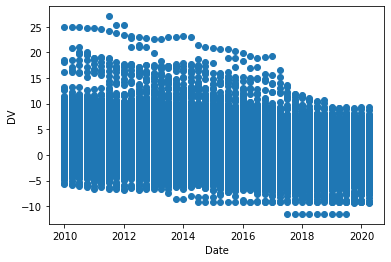

Train:  (53622, 8, 18) 53622
Valid:  (3035, 8, 18) 3035
Test:  (3035, 8, 18) 3035


In [ ]:
ts = 8
ts_out = 4
data, helper = extract_data(df_name='dataf_interp2', DV='lCloseAvg', drop=['name','Office','Close','lClose','CloseAvg'])
locals().update(helper)

vars = dv + ratios + macroec + ['CA','CN','OT','US']
data2, scalers, x_train, y_train, x_valid, y_valid, x_test, y_test, batch_arrays = \
    prepare_data_order(data, vars, val_mths=4, ts=ts)

### Set up parameters

In [ ]:
hidden_dim = 32
num_layers = 1
batch_size = 32
train_steps = 30
gamma = 1
n_windows = len(x_train)
n_seq_in = x_train.shape[2]
n_seq_out = 1
embed_dim = 4
kr = 0

### Set up input series


In [ ]:
# Extract input and random data
input_series1 = (tf.data.Dataset
               .from_tensor_slices(x_train))
input_series2 = (tf.data.Dataset
               .from_tensor_slices(y_train))
input_series3 = (tf.data.Dataset
               .from_tensor_slices(y_train))

input_series3_iter = iter(input_series3.repeat())
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# Input place holders
Xin1 = Input(shape=[ts, n_seq_in], name='RealDataX')
Xin2 = Input(shape=[ts_out, n_seq_out], name='RealDataY')
Xout = Input(shape=[ts_out, ts_out], name='SyntData')
Z = Input(shape=[ts_out, n_seq_out], name='RandomData')

### Define models

In [ ]:
embedder = model0(Xin1, Xin2, activ='linear',
                    name='Embedder', 
                    output_units=embed_dim, 
                    lstm_units=hidden_dim, 
                    kr=kr)
recovery = generic_layers(n_layers=num_layers, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq_out, 
                    name='Recovery',
                    activ='sigmoid')
generator = model0(Xin1, Xin2, activ='linear',
                    name='Generator', 
                    output_units=embed_dim, 
                    lstm_units=hidden_dim, 
                    kr=kr)
discriminator = model1(Xin1, Xout, activ='sigmoid',
                    name='Embedder', 
                    output_units=embed_dim, 
                    lstm_units=hidden_dim, 
                    kr=kr)
supervisor = generic_layers(n_layers=num_layers, 
                    hidden_units=hidden_dim, 
                    output_units=ts_out, 
                    name='Supervisor',
                    activ='linear')

### Train Autoencoder

Model: "Autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RealDataX (InputLayer)          [(None, 8, 18)]      0                                            
__________________________________________________________________________________________________
RealDataY (InputLayer)          [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 4, 4)         15108       RealDataX[0][0]                  
                                                                 RealDataY[0][0]                  
__________________________________________________________________________________________________
Recovery (Sequential)           (None, 4, 1)         4769        model[0][0]            

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:57<?, ?it/s]


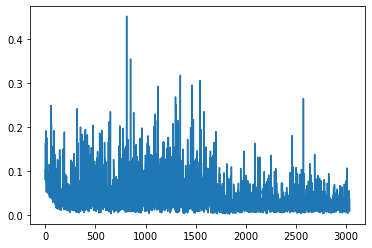

In [ ]:
### Train Autoencoder
H = embedder([Xin1,Xin2])
X_tilde = recovery(H)
autoencoder = Model(inputs=[Xin1,Xin2],
                    outputs=X_tilde,
                    name='Autoencoder')

autoencoder.summary()
plot_model(autoencoder, show_shapes=True)

# Autoencoder Training Loop
e_hist = []
for step in tqdm(range(train_steps)):
    for bstep in range(len(batch_arrays[0])):
        b_start = sum(batch_arrays[0][:bstep])
        b_end = b_start + batch_arrays[0][bstep]

        x_batch_train = x_train[b_start:b_end]
        y_batch_train = y_train[b_start:b_end]

        X1_ = tf.convert_to_tensor(x_batch_train, np.float32)
        X2_ = tf.convert_to_tensor(y_batch_train, np.float32)
        #X1_ = tf.convert_to_tensor(input_series1[b_start:b_end], np.float32)
        #X2_ = tf.convert_to_tensor(input_series2[b_start:b_end], np.float32)

        step_e_loss_t0 = train_autoencoder_init(X2_,[X1_,X2_])
        e_hist.append(np.float(step_e_loss_t0))
        with writer.as_default():
            tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)
        
        bstep +=1
        if bstep>=len(batch_arrays[0]):
            break
    if bstep>=len(batch_arrays[0]):
        break
plt.plot(e_hist)
plt.show()

### Train Supervisor

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:48<?, ?it/s]


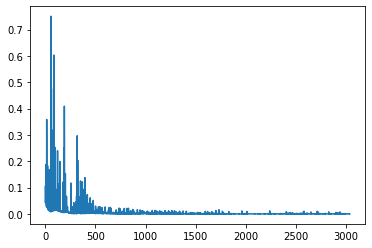

In [ ]:
### Train Supervisor
s_hist = []
#supervisor.summary()
for step in tqdm(range(train_steps)):
    for bstep in range(len(batch_arrays[0])):
        b_start = sum(batch_arrays[0][:bstep])
        b_end = b_start + batch_arrays[0][bstep]

        x_batch_train = x_train[b_start:b_end]
        y_batch_train = y_train[b_start:b_end]

        X1_ = tf.convert_to_tensor(x_batch_train, np.float32)
        X2_ = tf.convert_to_tensor(y_batch_train, np.float32)

        step_g_loss_s = train_supervisor([X1_,X2_])
        s_hist.append(np.float(step_g_loss_s))
        with writer.as_default():
            tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)
        
        bstep +=1
        if bstep>=len(batch_arrays[0]):
            break
    if bstep>=len(batch_arrays[0]):
        break

plt.plot(s_hist)
plt.show()

### Joint Training Generator

Model: "AdversarialNetSupervised"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RealDataX (InputLayer)          [(None, 8, 18)]      0                                            
__________________________________________________________________________________________________
RandomData (InputLayer)         [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 4, 4)         15108       RealDataX[0][0]                  
                                                                 RandomData[0][0]                 
__________________________________________________________________________________________________
Supervisor (Sequential)         (None, 4, 4)         4868        model_1[0]

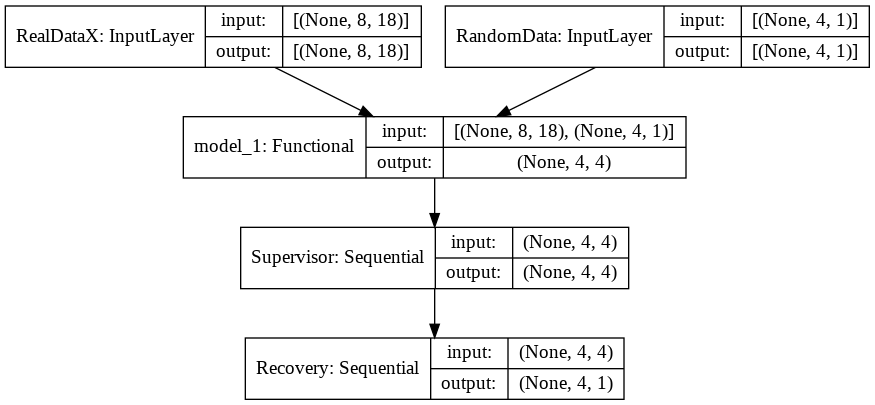

In [ ]:
#### Joint Training
# Generator
# Adversarial Architecture - Supervised
E_hat = generator([Xin1,Z])
if len(E_hat.shape)<3:
   E_hat = E_hat[:,:,None] # Added
H_hat = supervisor(E_hat)
if len(H_hat.shape)<3:
   H_hat = H_hat[:,:,None] # Added
Y_fake = discriminator([Xin1,H_hat])

adversarial_supervised = Model(inputs=[Xin1,Z],
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

adversarial_supervised.summary()
plot_model(adversarial_supervised, show_shapes=True)

# Adversarial Architecture in Latent Space
Y_fake_e = discriminator([Xin1,E_hat])

adversarial_emb = Model(inputs=[Xin1,Z],
                    outputs=Y_fake_e,
                    name='AdversarialNet')

adversarial_emb.summary()
plot_model(adversarial_emb, show_shapes=True)


# Mean and Variance Loss
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=[Xin1,Z],
                       outputs=X_hat,
                       name='SyntheticData')

synthetic_data.summary()
plot_model(synthetic_data, show_shapes=True)

### Joint Training Discriminator

Model: "DiscriminatorReal"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RealDataX (InputLayer)          [(None, 8, 18)]      0                                            
__________________________________________________________________________________________________
RealDataY (InputLayer)          [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 4, 4)         15108       RealDataX[0][0]                  
                                                                 RealDataY[0][0]                  
__________________________________________________________________________________________________
model_2 (Functional)            (None, 4, 1)         15393       RealDataX[0][0]  

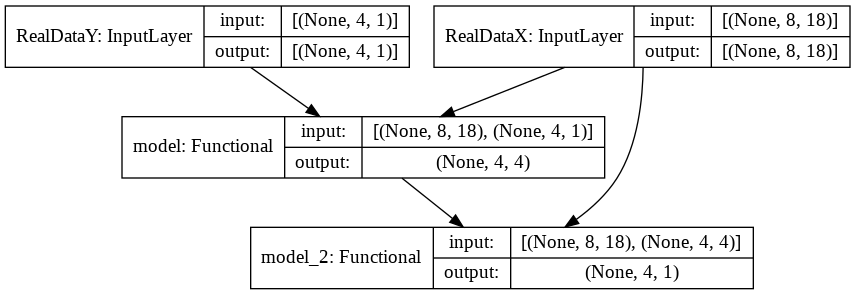

In [ ]:
#### Joint Training
# Discriminator
###############
# Architecture: Real Data
Y_real = discriminator([Xin1,H])
discriminator_model = Model(inputs=[Xin1,Xin2],
                            outputs=Y_real,
                            name='DiscriminatorReal')

discriminator_model.summary()
plot_model(discriminator_model, show_shapes=True)

### Joint Training Loop 30 epoch

In [ ]:
tf.config.run_functions_eagerly(True)
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
l_step_g_loss_u = []
l_step_g_loss_s = []
l_step_g_loss_v = []
l_step_e_loss_t0 = []
l_step_d_loss = []
discriminator_loss_real=0
l_discriminator_loss_real=[]
l_discriminator_loss_fake=[]
l_discriminator_loss_fake_e=[]
mse_test_epoch = []
mse_valid_epoch = []
fid_test_epoch = []
fid_valid_epoch = []

     0 |    100 | d_loss: 2.7836 | g_loss_u: 1.5469 | g_loss_s: 0.0144 | g_loss_v: 0.1665 | e_loss_t0: 0.0275
     0 |    200 | d_loss: 2.1199 | g_loss_u: 1.0555 | g_loss_s: 0.0007 | g_loss_v: 0.0294 | e_loss_t0: 0.0304
     0 |    300 | d_loss: 1.8763 | g_loss_u: 1.0937 | g_loss_s: 0.0005 | g_loss_v: 0.0203 | e_loss_t0: 0.0221
     0 |    400 | d_loss: 1.7784 | g_loss_u: 1.1078 | g_loss_s: 0.0006 | g_loss_v: 0.0389 | e_loss_t0: 0.0232
     0 |    500 | d_loss: 1.8747 | g_loss_u: 1.0682 | g_loss_s: 0.0005 | g_loss_v: 0.0511 | e_loss_t0: 0.0182
     0 |    600 | d_loss: 1.9986 | g_loss_u: 1.2748 | g_loss_s: 0.0001 | g_loss_v: 0.0764 | e_loss_t0: 0.0080
     0 |    700 | d_loss: 1.7843 | g_loss_u: 1.1640 | g_loss_s: 0.0005 | g_loss_v: 0.0922 | e_loss_t0: 0.0180
     0 |    800 | d_loss: 1.9200 | g_loss_u: 1.2509 | g_loss_s: 0.0002 | g_loss_v: 0.1012 | e_loss_t0: 0.0047
     0 |    900 | d_loss: 1.9025 | g_loss_u: 1.0913 | g_loss_s: 0.0001 | g_loss_v: 0.0202 | e_loss_t0: 0.0032
     0 |  

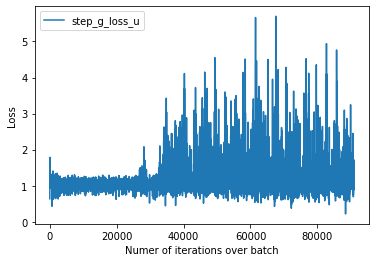

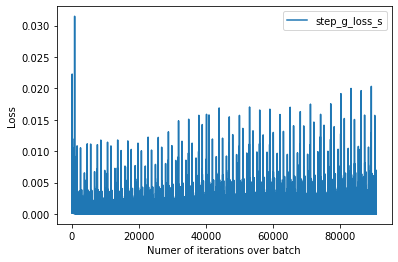

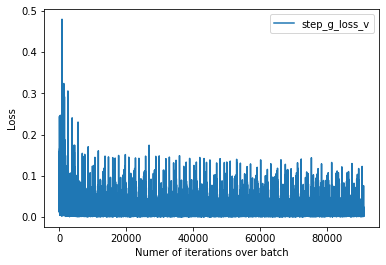

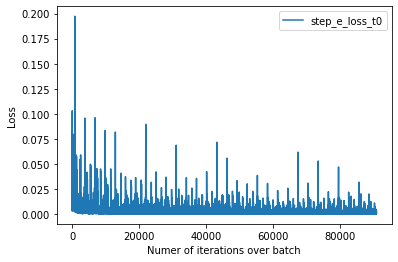

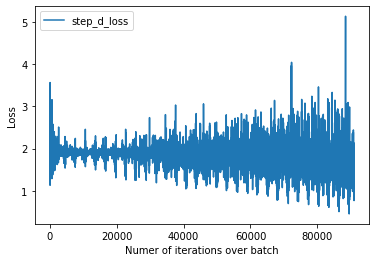

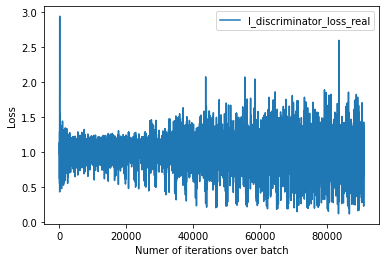

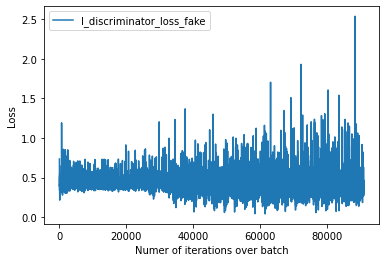

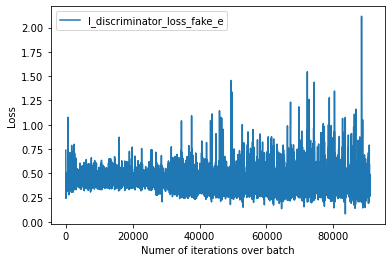

In [ ]:
### Training Loop
for step in range(train_steps):
  # Train generator (twice as often as discriminator)
    for bstep in range(len(batch_arrays[0])):
        for kk in range(2):
            b_start = sum(batch_arrays[0][:bstep])
            b_end = b_start + batch_arrays[0][bstep]

            x_batch_train = x_train[b_start:b_end]
            y_batch_train = y_train[b_start:b_end]

            X1_ = tf.convert_to_tensor(x_batch_train, np.float32)
            X2_ = tf.convert_to_tensor(y_batch_train, np.float32)
            #X1_ = X1_[:,:,None]
            Z_ = next(random_series)[:y_batch_train.shape[0],:,:1]

            # Train generator
            step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X2_, [X1_,X2_], [X1_,Z_])
            # Train embedder
            step_e_loss_t0 = train_embedder(X2_,[X1_,X2_])

            bstep +=1
            if bstep>=len(batch_arrays[0]):
                break
        if bstep>=len(batch_arrays[0]):
            break

        b_start = sum(batch_arrays[0][:bstep])
        b_end = b_start + batch_arrays[0][bstep]

        x_batch_train = x_train[b_start:b_end]
        y_batch_train = y_train[b_start:b_end]

        X1_ = tf.convert_to_tensor(x_batch_train, np.float32)
        X2_ = tf.convert_to_tensor(y_batch_train, np.float32)
        #X1_ = X1_[:,:,None]
        Z_ = next(random_series)[:y_batch_train.shape[0],:,:1]

        step_d_loss, discriminator_loss_real, discriminator_loss_fake, discriminator_loss_fake_e = get_discriminator_loss([X1_,X2_], [X1_,Z_])
        #if step_d_loss > 0.15:
        if step_d_loss > 0.2:
            step_d_loss, discriminator_loss_real, discriminator_loss_fake, discriminator_loss_fake_e = train_discriminator([X1_,X2_], [X1_,Z_])

        l_step_g_loss_u.append(step_g_loss_u)
        l_step_g_loss_s.append(step_g_loss_s)
        l_step_g_loss_v.append(step_g_loss_v)
        l_step_e_loss_t0.append(step_e_loss_t0)
        l_step_d_loss.append(step_d_loss)
        l_discriminator_loss_real.append(discriminator_loss_real)
        l_discriminator_loss_fake.append(discriminator_loss_fake)
        l_discriminator_loss_fake_e.append(discriminator_loss_fake_e)
        if bstep % 100 == 0:
            print(f'{step:6,.0f} | {bstep:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
                  f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

        with writer.as_default():
            tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
            tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
            tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
            tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
            tf.summary.scalar('D Loss', step_d_loss, step=step)

    # Calculate MSE on train data
    zt_data = []
    for i in range(int(len(x_train)/batch_size)+1):
        Z_ = next(random_series)
        zt_data.append(Z_.numpy())
    Z = np.concatenate([df for df in zt_data])[:len(x_train),:,:1]
    # Calculate predicted values
    generated_datatt = synthetic_data([x_train,Z])[:,:,0]
    yhattt = (scalers[1].inverse_transform(generated_datatt)
                  .reshape(-1, ts_out, n_seq_out))[:,:,0]

    y_acttt = scalers[1].inverse_transform(y_train) # unnormalize
    mset = mean_squared_error(y_acttt, yhattt)
    fidt = calculate_fid(y_acttt, yhattt)

    # Calculate MSE on validation data
    zt_data = []
    for i in range(int(len(x_valid)/batch_size)+1):
        Z_ = next(random_series)
        zt_data.append(Z_.numpy())
    Z = np.concatenate([df for df in zt_data])[:len(x_valid),:,:1]
    # Calculate predicted values
    generated_datav = synthetic_data([x_valid,Z])[:,:,0]
    yhatv = (scalers[1].inverse_transform(generated_datav)
                  .reshape(-1, ts_out, n_seq_out))[:,:,0]

    y_actv = scalers[1].inverse_transform(y_valid) # unnormalize
    
    # Print MSE
    msev = mean_squared_error(y_actv, yhatv)
    fidv = calculate_fid(y_actv, yhatv)

    mse_test_epoch.append(mset)
    mse_valid_epoch.append(msev)
    fid_test_epoch.append(fidt)
    fid_valid_epoch.append(fidv)
    print("MSE on Test & Validation data:")
    print('Train MSE: %.3f' % mset, 'Validation MSE: %.3f' % msev, 'Train FID: %.3f' % fidt, 'Validation FID: %.3f' % fidv)

plt.plot(l_step_g_loss_u, label='step_g_loss_u')
plt.legend()
plt.xlabel("Numer of iterations over batch")
plt.ylabel("Loss")
plt.show()
plt.plot(l_step_g_loss_s, label='step_g_loss_s')
plt.legend()
plt.xlabel("Numer of iterations over batch")
plt.ylabel("Loss")
plt.show()
plt.plot(l_step_g_loss_v, label='step_g_loss_v')
plt.legend()
plt.xlabel("Numer of iterations over batch")
plt.ylabel("Loss")
plt.show()
plt.plot(l_step_e_loss_t0, label='step_e_loss_t0')
plt.legend()
plt.xlabel("Numer of iterations over batch")
plt.ylabel("Loss")
plt.show()
plt.plot(l_step_d_loss, label='step_d_loss')
plt.legend()
plt.xlabel("Numer of iterations over batch")
plt.ylabel("Loss")
plt.show()
plt.plot(l_discriminator_loss_real, label='l_discriminator_loss_real')
plt.legend()
plt.xlabel("Numer of iterations over batch")
plt.ylabel("Loss")
plt.show()
plt.plot(l_discriminator_loss_fake, label='l_discriminator_loss_fake')
plt.legend()
plt.xlabel("Numer of iterations over batch")
plt.ylabel("Loss")
plt.show()
plt.plot(l_discriminator_loss_fake_e, label='l_discriminator_loss_fake_e')
plt.legend()
plt.xlabel("Numer of iterations over batch")
plt.ylabel("Loss")
plt.show()

### Predict 10 epoch

Performance on Train data:
Train MSE: 0.465
Train FID: 0.096
Performance on Validation data:
Validation MSE: 0.799
Validation FID: 0.990
Performance on Test data:
Test RMSE: 1.019
Test MAE: 0.801
Test RMSE period 0: 1.108
Test RMSE period 1: 0.892
Test RMSE period 2: 1.143
Test RMSE period 3: 0.908
Test MAE period 0: 0.922
Test MAE period 1: 0.713
Test MAE period 2: 0.979
Test MAE period 3: 0.591
Test FID: 1.636
Full RMSE: 0.761
Full RMSE period 0: 0.788
Full RMSE period 1: 0.740
Full RMSE period 2: 0.749
Full RMSE period 3: 0.766
Full FID: 0.240


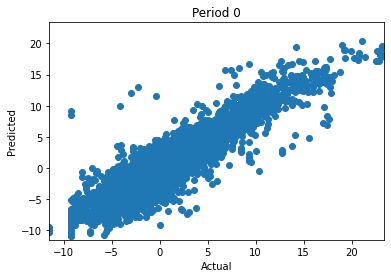

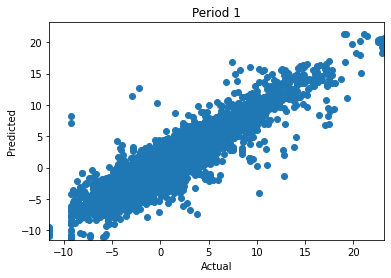

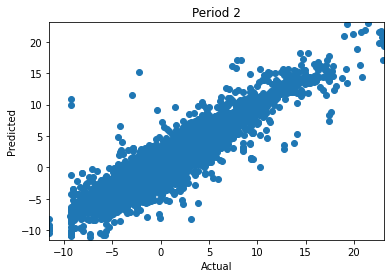

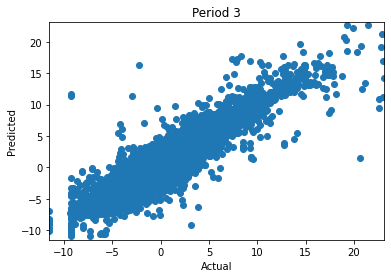

In [ ]:
# Calculate Predictions
all_lag, y_act, yhat, y_actt, yhatt, impt_var, mset, msev = prediction(scalers, importance=0)

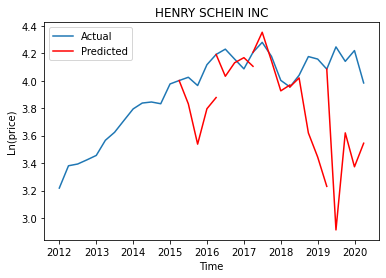

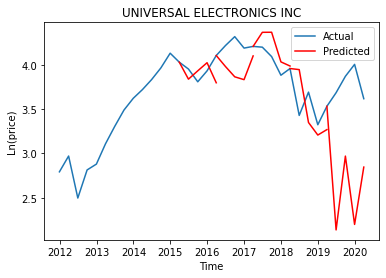

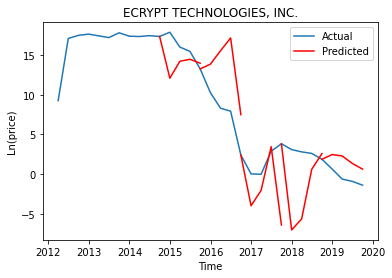

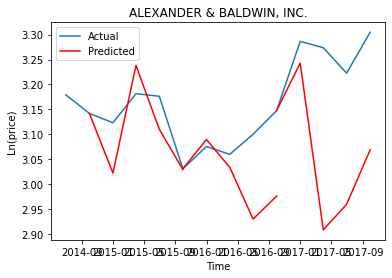

2508    0.350637
Name: dif, dtype: float64
1972    0.439811
Name: dif, dtype: float64
6.210236356494333
0.11184840215194146


In [ ]:
# Plots
ydiff = pd.DataFrame(index = all_lag.index, columns=['dif'])
ydiff['dif'] = (y_act - yhat)**2
ydiff_co = np.sqrt(ydiff.reset_index().groupby('cik').mean('dif'))
ydiff_co = ydiff_co.sort_values(by='dif',ascending=False)
ydiff_co = ydiff_co.reset_index()

# Actual vs Predicted plots
f_yr=5 # number of years for comparison
step=4 # step in quarters
sample_plot(co=companies[0], f_yr=f_yr, step=step)
sample_plot(co=companies[100], f_yr=f_yr, step=step)
sample_plot(co=ydiff_co.iloc[0,0], f_yr=f_yr, step=step) # worst fit
sample_plot(co=ydiff_co.iloc[-1,0], f_yr=f_yr, step=step) # best fit
print(ydiff_co.loc[ydiff_co.cik==companies[0],'dif'])
print(ydiff_co.loc[ydiff_co.cik==companies[100],'dif'])
print(ydiff_co.iloc[0,1])
print(ydiff_co.iloc[-1,1])

In [ ]:
pd.DataFrame(mse_test_epoch).to_csv("mse_test_mult2.csv")
pd.DataFrame(mse_valid_epoch).to_csv("mse_valid_mult2.csv")
pd.DataFrame(fid_test_epoch).to_csv("fid_test_mult2.csv")
pd.DataFrame(fid_valid_epoch).to_csv("fid_valid_mult2.csv")

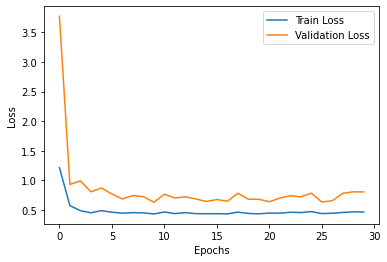

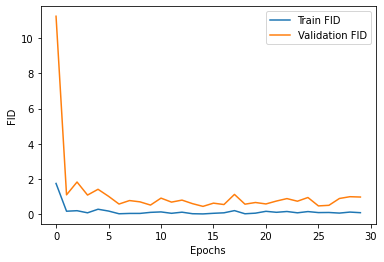

In [ ]:
plt.plot(mse_test_epoch, label='Train Loss')
plt.plot(mse_valid_epoch, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(fid_test_epoch, label='Train FID')
plt.plot(fid_valid_epoch, label='Validation FID')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.show()

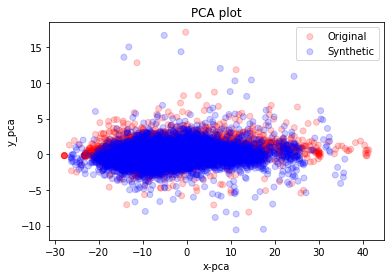

In [ ]:
PCA_Analysis(y_act, yhat)

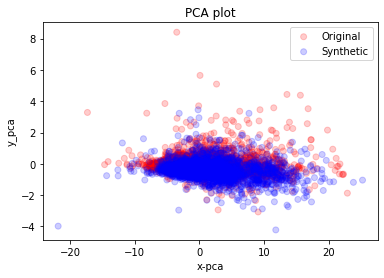

In [ ]:
PCA_Analysis(y_actt, yhatt)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 155604 samples in 0.135s...
[t-SNE] Computed neighbors for 155604 samples in 8.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 155604
[t-SNE] Computed conditional probabilities for sample 2000 / 155604
[t-SNE] Computed conditional probabilities for sample 3000 / 155604
[t-SNE] Computed conditional probabilities for sample 4000 / 155604
[t-SNE] Computed conditional probabilities for sample 5000 / 155604
[t-SNE] Computed conditional probabilities for sample 6000 / 155604
[t-SNE] Computed conditional probabilities for sample 7000 / 155604
[t-SNE] Computed conditional probabilities for sample 8000 / 155604
[t-SNE] Computed conditional probabilities for sample 9000 / 155604
[t-SNE] Computed conditional probabilities for sample 10000 / 155604
[t-SNE] Computed conditional probabilities for sample 11000 / 155604
[t-SNE] Computed conditional probabilities for sample 12000 / 155604
[t-SNE] Computed conditional probab

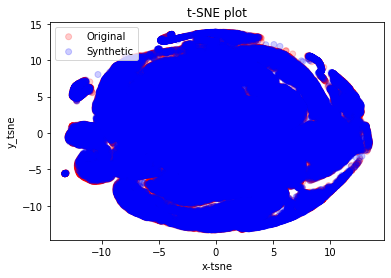

In [ ]:
tSNE_Analysis(y_act, yhat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5870 samples in 0.003s...
[t-SNE] Computed neighbors for 5870 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5870
[t-SNE] Computed conditional probabilities for sample 2000 / 5870
[t-SNE] Computed conditional probabilities for sample 3000 / 5870
[t-SNE] Computed conditional probabilities for sample 4000 / 5870
[t-SNE] Computed conditional probabilities for sample 5000 / 5870
[t-SNE] Computed conditional probabilities for sample 5870 / 5870
[t-SNE] Mean sigma: 0.194402
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.345253
[t-SNE] KL divergence after 300 iterations: 1.714831


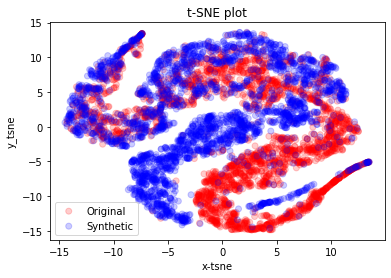

In [ ]:
tSNE_Analysis(y_actt, yhatt)